
image 1/1 d:\Study\XLA\Project\images\cars.jpg: 448x640 1 person, 6 cars, 1 bus, 1 truck, 1 umbrella, 59.8ms
Speed: 1.9ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
Found 10 boxes for cars.jpg
car 0.91 (611, 226) (727, 378)
car 0.89 (23, 203) (220, 371)
person 0.89 (171, 215) (296, 397)
car 0.87 (294, 181) (514, 373)
car 0.82 (517, 187) (687, 364)
truck 0.69 (0, 93) (194, 373)
bus 0.51 (161, 98) (427, 215)
car 0.47 (267, 220) (315, 343)
umbrella 0.46 (204, 190) (306, 221)
car 0.39 (480, 216) (533, 277)


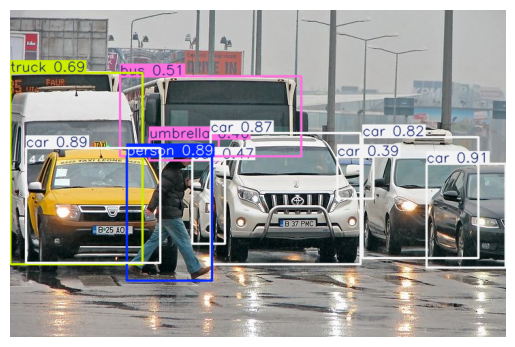

In [2]:
# Import các thư viện cần thiết
from ultralytics import YOLO
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn đến hình ảnh đầu vào
input_image_name = "cars.jpg"
input_image_path = os.path.join("images", input_image_name)

# Tạo thư mục output nếu chưa tồn tại
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Tải mô hình YOLOv8 được huấn luyện sẵn
model = YOLO('yolov8n.pt')  # Bạn có thể chọn 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt' tùy theo yêu cầu

# Thực hiện phát hiện vật thể trên hình ảnh
results = model(input_image_path)

# Lấy kết quả từ kết quả đầu ra
result = results[0]

# Lấy thông tin bounding boxes, scores và class IDs
boxes = result.boxes.xyxy.cpu().numpy()  # Tọa độ bounding boxes (x1, y1, x2, y2)
scores = result.boxes.conf.cpu().numpy()  # Độ tin cậy của từng bounding box
class_ids = result.boxes.cls.cpu().numpy().astype(int)  # ID của lớp dự đoán
class_names = model.names  # Tên các lớp

# In ra kết quả
print('Found {} boxes for {}'.format(len(boxes), input_image_name))
for i in range(len(boxes)):
    class_id = class_ids[i]
    class_name = class_names[class_id]
    box = boxes[i]
    score = scores[i]
    left, top, right, bottom = box
    label = '{} {:.2f}'.format(class_name, score)
    print('{} ({}, {}) ({}, {})'.format(label, int(left), int(top), int(right), int(bottom)))

# Vẽ bounding boxes lên hình ảnh
annotated_image = result.plot()

# Lưu hình ảnh kết quả
output_image_path = os.path.join(output_dir, input_image_name)
cv2.imwrite(output_image_path, annotated_image)

# Hiển thị hình ảnh
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Sử dụng thiết bị: cpu


c:\Users\vuklu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vuklu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


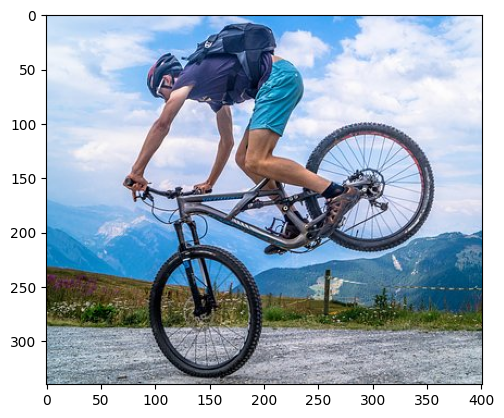

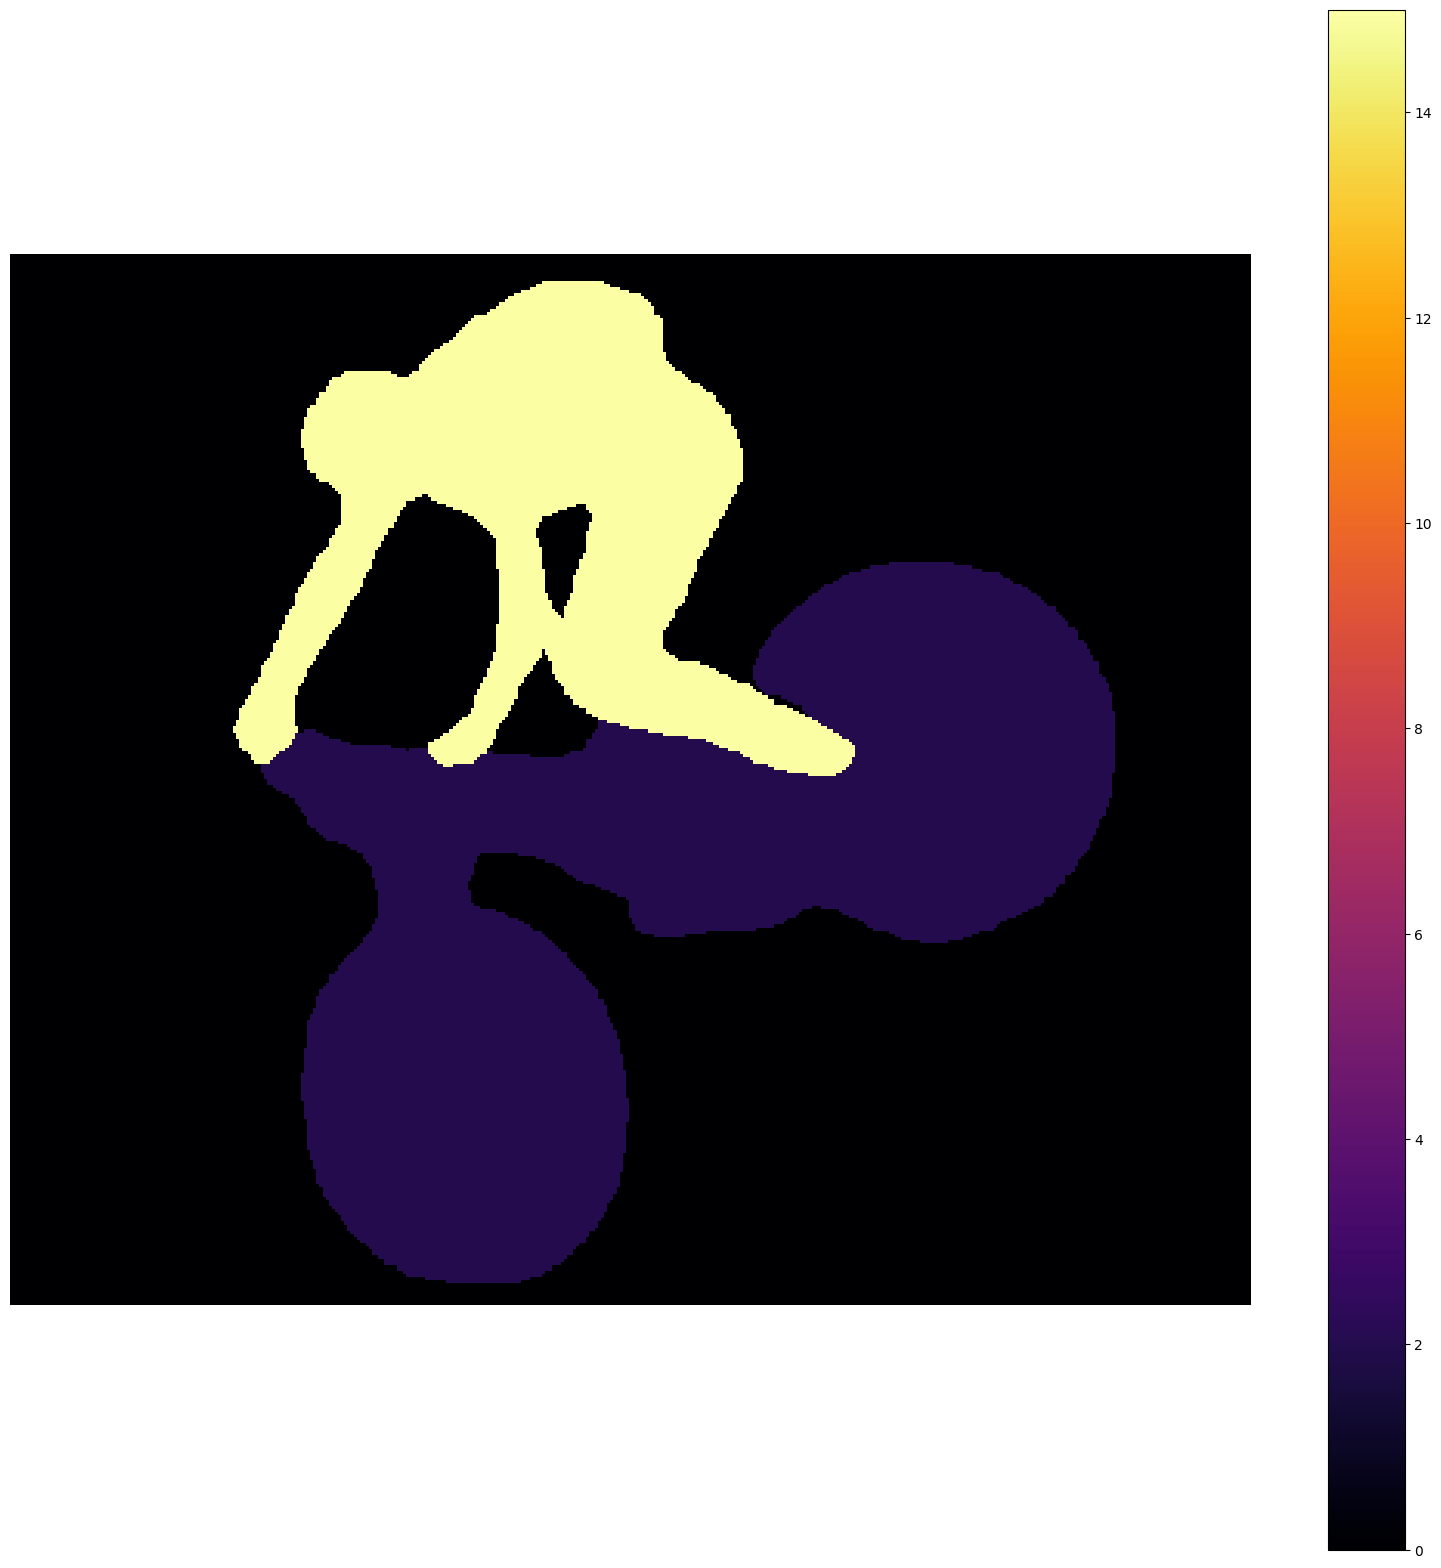

In [3]:
from matplotlib import pyplot as pylab
import numpy as np
import torch
import torchvision
from PIL import Image, ImageOps
import os

# Kiểm tra thiết bị (CPU hoặc GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Sử dụng thiết bị: {device}')

# Tải mô hình DeepLabV3 đã được huấn luyện sẵn
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.to(device)
model.eval()

# Đường dẫn đến thư mục input và output
pathIn = 'images'  # Thư mục chứa hình ảnh đầu vào
pathOut = 'output'  # Thư mục chứa kết quả phân đoạn

# Đảm bảo thư mục output tồn tại
os.makedirs(pathOut, exist_ok=True)

# Tên hình ảnh đầu vào
image_name = "cycle.jpg"
image_path = os.path.join(pathIn, image_name)
pylab.imshow(Image.open(image_path))

# Đọc hình ảnh và chuyển sang RGB
image = Image.open(image_path).convert('RGB')
original_size = image.size  # (width, height)

# Thay đổi kích thước hình ảnh để chiều lớn nhất là 512
max_dim = 512
w, h = image.size
ratio = max_dim / max(w, h)
new_size = (int(w * ratio), int(h * ratio))
resized_image = image.resize(new_size, Image.LANCZOS)

# Thêm padding để hình ảnh có kích thước 512x512
pad_w = max_dim - new_size[0]
pad_h = max_dim - new_size[1]
padded_image = ImageOps.expand(resized_image, border=(0, 0, pad_w, pad_h), fill=0)

# Chuyển đổi hình ảnh thành tensor và chuẩn hóa
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(padded_image).unsqueeze(0).to(device)  # Thêm batch dimension

# Thực hiện phân đoạn
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # Loại bỏ batch dimension

# Lấy bản đồ phân đoạn
output_predictions = output.argmax(0).cpu().numpy().astype(np.uint8)

# Loại bỏ padding khỏi bản đồ phân đoạn
output_predictions = output_predictions[:new_size[1], :new_size[0]]

# Thay đổi kích thước bản đồ phân đoạn về kích thước gốc
segmentation_map = Image.fromarray(output_predictions)
segmentation_map = segmentation_map.resize((w, h), resample=Image.NEAREST)
segmentation_map = np.array(segmentation_map)

# Hiển thị và lưu kết quả phân đoạn
pylab.figure(figsize=(20, 20))
pylab.imshow(segmentation_map, cmap='inferno')
pylab.axis('off')
pylab.colorbar()
pylab.show()

# Lưu hình ảnh kết quả
output_image_path = os.path.join(pathOut, "segmented.jpg")
pylab.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
pylab.close()
